# Forecasting a Time Series

In [1]:
import pandas as pd
from pathlib import Path

path = Path('/content/CTA_-_Ridership_-_Daily_Boarding_Totals_20260107.csv')

# read in data & convert date into datetime obj instead of keeping it
# as a generic obj type
df = pd.read_csv(path, parse_dates=['service_date'])

# rename cols
df.columns = ['date','day_type','bus','rail','total']

# sort and set date col as row index
df = df.sort_values('date').set_index('date')

# drop total col
df = df.drop('total', axis = 1)

# drop duplicate values
df = df.drop_duplicates()

In [2]:
# show first five rows
df.head()

# day_type:
# W = weekday
# A for saturday
# U for sunday or holiday

,day_type,bus,rail
date,,,
2001-01-01,U,"297,192","126,455"
2001-01-02,W,"780,827","501,952"
2001-01-03,W,"824,923","536,432"
2001-01-04,W,"870,021","550,011"
2001-01-05,W,"890,426","557,917"


In [3]:
df['2019-03':'2019-05']

,day_type,bus,rail
date,,,
2019-03-01,W,"812,238","682,969"
2019-03-02,A,"454,119","349,392"
2019-03-03,U,"313,539","252,150"
2019-03-04,W,"699,086","635,353"
2019-03-05,W,"761,781","692,945"
...,...,...,...
2019-05-27,U,"298,987","256,757"
2019-05-28,W,"769,069","694,292"
2019-05-29,W,"791,059","717,681"


In [4]:
## strip commas from numeric fields so they can be transformed into integers
df['bus'] = df['bus'].str.replace(',','')
df['rail'] = df['rail'].str.replace(',','')

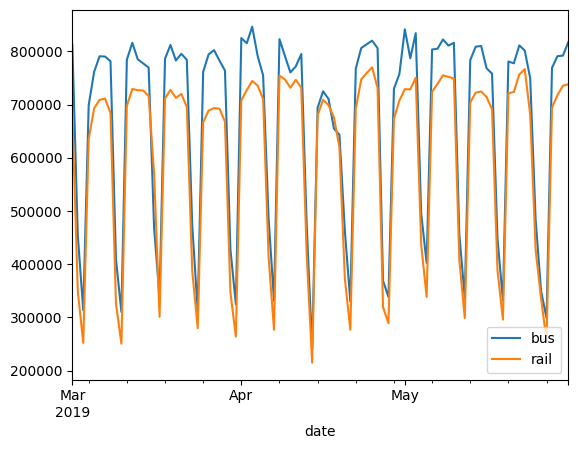

In [5]:
## plot bus / rail ridership over few months in 2019
import matplotlib.pyplot as plt

# turn str data into int for plotting and subset df to plot
df['bus'] = df['bus'].apply(lambda x: int(x))
df['rail'] = df['rail'].apply(lambda x: int(x))

df['2019-03':'2019-05'].plot()

plt.show()

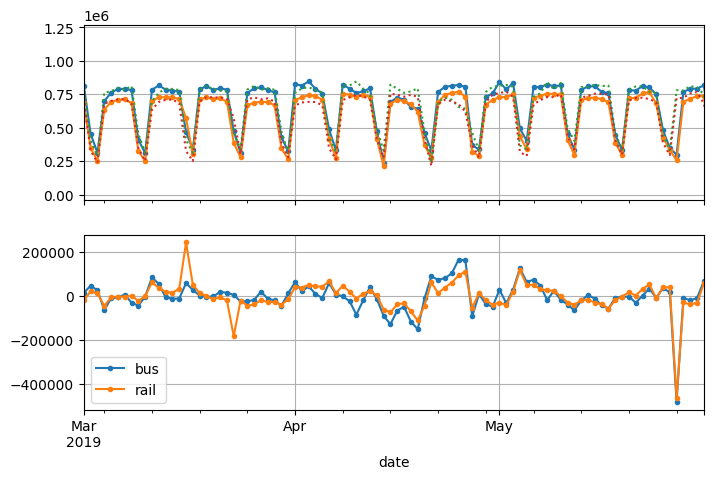

In [6]:
# create a 7-day difference time series
diff_7 = df[['bus','rail']].diff(7)['2019-03':'2019-05']

# create plots
fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))

# plot og time series
df.plot(ax = axs[0], legend=False, marker='.')

# plot lagged time series
df.shift(7).plot(ax = axs[0], grid = True, legend = False, linestyle=':')

# 7-day difference time series (t vs. t-7)
diff_7.plot(ax = axs[1], grid = True, marker = '.')

plt.show();

In [7]:
## identify memorial day during big difference found in may
list(df.loc['2019-05-25':'2019-05-27']['day_type'])

['A', 'U', 'U']

In [8]:
# calculate MAE of naive forecast
diff_7.abs().mean()

,0
bus,43915.608696
rail,42143.271739


In [9]:
## calculate MAPE
targets = df[['bus','rail']]['2019-03':'2019-05']
(diff_7 / targets).abs().mean()

,0
bus,0.082938
rail,0.089948


We see here that the error is lower for bus than for rail. While error in MAE was better for rail, overall ridership is more for bus. When put into perspective, the bus forecasting is actually better than rail.

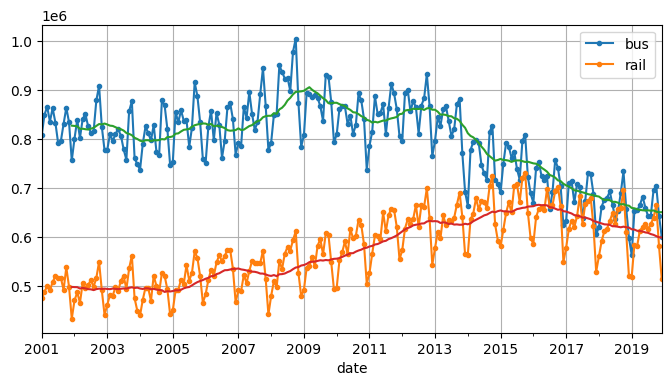

In [10]:
# look for yearly seasonality
# look at 12-month rolling average for each series
period = slice('2001', '2019')

# calculate mean for month end bins
df_monthly = df.select_dtypes(include='number').resample('ME').mean()

# create rolling average
rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8,4))

# plot monthly data
df_monthly[period].plot(ax = ax, marker = '.')

# plot 12 month averages
rolling_average_12_months.plot(ax = ax, grid = True, legend = False)

plt.show();

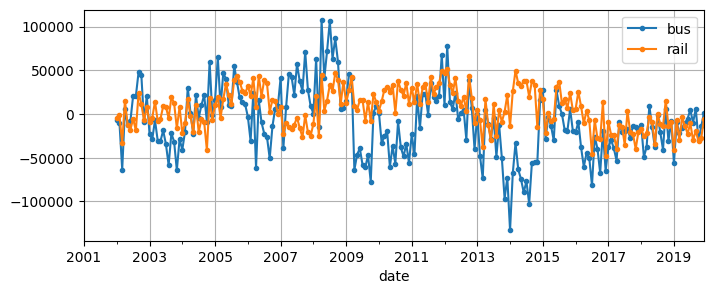

In [11]:
## plot difference over 12 months
df_monthly.diff(12)[period].plot(grid = True, marker = '.', figsize=(8,3))
plt.show();

By differencing out the values, we can remove some of the long-term trends seen in the model. We can build a model off of this and then re-add back in the terms that were subtracted earlier.

## ARIMA

In [12]:
# act like it's the last day of may 2019 and we want to forecast for june 1 2019
from statsmodels.tsa.arima.model import ARIMA

origin, today = '2019-01-01', '2019-05-31'

# grab data from origin through last day of may, time series data to daily
rail_series = df.loc[origin:today]['rail'].asfreq('D')

# build model
model = ARIMA(rail_series, order = (1,0,0), seasonal_order=(0,1,1,7))

# order params are p, d, q
# p -> how far back to look
# d -> degree / differencing
# q -> past forecast errors

# seasonal_order params are P, D, Q, s
# P, D, Q model seasonal params
# s -> period of seasonal pattern
# P, D, Q model time series at t - s, t - 2s, etc.

# fit
model = model.fit()

# forecast
y_pred = model.forecast()

print(y_pred)

2019-06-01    427758.626288
Freq: D, dtype: float64


In [13]:
## loop to make forecasts for every day in March, April & May and compute MAE
origin, start_date, end_date = '2019-01-01', '2019-03-01', '2019-05-31'

time_period = pd.date_range(start_date, end_date)

rail_series = df.loc[origin:end_date]['rail'].asfreq('D')

y_preds = []

# s is 7 due to strong weekly seasonality
for today in time_period.shift(-1):
  # train on data up to "today"
  model = ARIMA(rail_series[origin:today], order = (1,0,0),
                seasonal_order=(0,1,1,7))
  model = model.fit()
  y_pred = model.forecast().iloc[0]
  y_preds.append(y_pred)

# calculate mae
y_preds = pd.Series(y_preds, index = time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

print(mae)

32040.72009292839


## Preparing the Data for Machine Learning Models

In [14]:
## goal to forecast tomorrow's ridership based on past 56 days
# use 56-day windown from past as training data and
# the target associated with each window of training data will be
# the immediate value after it

# create custom dataset to chop time series into all the possible windows
# for a length given to it, and grab the appropriate target
import torch

class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, series, window_length):
    self.series = series
    self.window_length = window_length

  def __len__(self):
    # get diff b/w series and the length of the window
    # useful to understand how many sequences we'll get
    return len(self.series) - self.window_length

  def __getitem__(self, index):
    if index >= len(self):
      raise IndexError('dataset index out of range.')

    # grab first index after the window
    end = index + self.window_length

    # grab window
    window = self.series[index:end]

    # grab target
    target = self.series[end]

    return window, target

In [15]:
# test this out
my_series = torch.tensor([[0],[1],[2],[3],[4],[5]])

my_dataset = TimeSeriesDataset(my_series, window_length = 3)

for window, target in my_dataset:
  print('window:',window, 'target:',target)

print('sequences in dataset:',len(my_dataset))

window: tensor([[0],
        [1],
        [2]]) target: tensor([3])
window: tensor([[1],
        [2],
        [3]]) target: tensor([4])
window: tensor([[2],
        [3],
        [4]]) target: tensor([5])
sequences in dataset: 3


In [17]:
## create dataloader to shuffle the windows and to group them into batches of
## size 2
from torch.utils.data import DataLoader

torch.manual_seed(0)

my_loader = DataLoader(my_dataset, batch_size = 2, shuffle = True)

for window, target in my_loader:
  print('window:',window, 'target:',target)

window: tensor([[[0],
         [1],
         [2]],

        [[2],
         [3],
         [4]]]) target: tensor([[3],
        [5]])
window: tensor([[[1],
         [2],
         [3]]]) target: tensor([[4]])


In [18]:
## create train, val, test sets for rail data
## first of all, we scale data by factor of 1 mil; convert data to 32-bit
## float tensors, as well
rail_train = torch.FloatTensor(df[['rail']]['2016-01':'2018-12'].values / 1e6)
rail_val = torch.FloatTensor(df[['rail']]['2019-01':'2019-05'].values / 1e6)
rail_test = torch.FloatTensor(df[['rail']]['2019-06':].values / 1e6)

In [19]:
## create datasets and loaders for ridership data
window_length = 56 # remember, days...

train_set = TimeSeriesDataset(rail_train, window_length)
val_set = TimeSeriesDataset(rail_val, window_length)
test_set = TimeSeriesDataset(rail_test, window_length)

train_loader = DataLoader(train_set, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_set, batch_size = 32)
test_loader = DataLoader(test_set, batch_size = 32)

## Forecasting Using a Linear Model

In [20]:
# set device depending on what's available
if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

In [21]:
## build a linear model that uses huber loss instead of directly
## trying to minimize mae; huber is differentiable at all points,
## making it better for gradient-based methods
# train function to implement mb gd
def train_mbgd(model, optimizer, criterion, train_loader, n_epochs):
  model.train() # set training mode
  for epoch in range(n_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
      # get batch
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      # mod pred
      y_pred = model(X_batch)
      # calc loss and tally
      loss = criterion(y_pred, y_batch)
      total_loss += loss.item()
      # calc grads and do step
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    mean_loss = total_loss / len(train_loader)
    if epoch % 10 == 0: # every ten epochs, print out loss
      print(f'Epoch {epoch + 1}, Loss: {mean_loss}')

In [24]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.2 MB/s eta 0:00:00


In [25]:
torch.manual_seed(42)
import torch.nn as nn
import torchmetrics

model = nn.Sequential(nn.Flatten(),nn.Linear(window_length,1)).to(device)
loss_fn = nn.HuberLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum = 0.9)
metric = torchmetrics.MeanAbsoluteError().to(device)

train_mbgd(model, optimizer, loss_fn, train_loader, n_epochs = 100)

Epoch 1, Loss: 0.015443495460644815
Epoch 11, Loss: 0.004364780820623943
Epoch 21, Loss: 0.003821369964333082
Epoch 31, Loss: 0.0034842180797237565
Epoch 41, Loss: 0.0032637645278803325
Epoch 51, Loss: 0.0031974380765336027
Epoch 61, Loss: 0.0030081975414897456
Epoch 71, Loss: 0.0029514124969754257
Epoch 81, Loss: 0.0029313621202935324
Epoch 91, Loss: 0.002820470881874137


In [26]:
## create evaluation function
def evaluate(model, data_loader, metric, aggregate = torch.mean):
  model.eval() # change model mode to evaluation (no gradient work)
  metrics = []

  with torch.no_grad():
    for X_batch, y_batch in data_loader:
      # move data to GPU / cuda
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      y_pred = model(X_batch)
      metric_val = metric(y_pred, y_batch)
      metrics.append(metric_val)

  # retrun agg met over all batches
  return aggregate(torch.stack(metrics))

In [31]:
# calculate test set mae
val_mae = evaluate(model, val_loader, metric)

# remember to de-scale it
print(f'Validation MAE: {val_mae.item()*1e6}')

Test MAE: 37898.48834276199


## Forecasting Using a Simple RNN

In [37]:
class SimpleRNNModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.memory_cell = nn.Sequential(
        nn.Linear(input_size + hidden_size, hidden_size),
        nn.Tanh()
    )
    self.output = nn.Linear(hidden_size, output_size)

  def forward(self, X):
    # pull out dims of X
    # each batch is [batch, window, dims]
    batch_size, window_length, dimensionality = X.shape
    # swap first two dims
    # input tensor at each time step is
    # [batch, dims]
    X_time_first = X.transpose(0,1)
    # hidden cell initialized to zeros; for each input window,
    # there is going to be one zero for each recurrent neuron
    # this means the shape is [batch, dim]
    H = torch.zeros(batch_size, self.hidden_size, device=X.device)
    # begin loop
    for X_t in X_time_first:
      # want to feed both curr inputs & hidden state H to mem cell;
      # to do this, concat along dim 1, results in shape:
      # [batch, input_size + hidden_size]
      XH = torch.cat((X_t, H), dim=1)
      H = self.memory_cell(XH)

    # gives pred of [batch_size, output_size]
    return self.output(H)

In [49]:
def evaluate_tm(model, data_loader, metric):
    model.eval() # eval mode
    metric.reset() # reset metric
    # no grad updates
    with torch.no_grad():
      # load in data / batches
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # get model preds
            y_pred = model(X_batch)
            # update metric
            metric.update(y_pred, y_batch)
    # compute metric / result
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs, patience=10, factor=0.1):
    # add reduce LR on plateau scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=patience, factor=factor)
    # dict of lists to store vals
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
      # get starting params
        total_loss = 0.0
        metric.reset()
        model.train() # train mode
        # load in data / batches
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # model pred
            y_pred = model(X_batch)
            # calc loss and add to total
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            # gradient update
            loss.backward()
            # adjust optimizer then zero out grads
            optimizer.step()
            optimizer.zero_grad()
            # accumulate metric over epoch
            metric.update(y_pred, y_batch)

        # add train and valid metrics
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())

        val_metric = evaluate_tm(model, valid_loader, metric).item()

        history["valid_metrics"].append(val_metric)

        # move / adjust scheduler
        scheduler.step(val_metric)

        # print out epoch metrics
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")

    return history

In [51]:
# train rnn model using same funcs as before
def fit_and_evaluate(model, train_loader, valid_loader, lr, n_epochs=50,
                     patience=20, factor=0.1):
    loss_fn = nn.HuberLoss()

    # adding momentum to help with stagnating loss vals
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=lr, momentum=0.95)

    metric = torchmetrics.MeanAbsoluteError().to(device)

    history = train(model, optimizer, loss_fn, metric,
                    train_loader, valid_loader, n_epochs=n_epochs,
                    patience=patience, factor=factor)
    # get smallest value and de-scale
    return min(history["valid_metrics"]) * 1e6

# univariate time series, so input size is 1
# dim is 32
# output is 1
torch.manual_seed(42)

univar_model = SimpleRNNModel(input_size=1, hidden_size=32,
                              output_size=1)
univar_model = univar_model.to(device)
fit_and_evaluate(univar_model, train_loader, val_loader,
                 lr=0.05, n_epochs=50)

Epoch 1/50, train loss: 0.0523, train metric: 0.2600, valid metric: 0.2126
Epoch 2/50, train loss: 0.0174, train metric: 0.1542, valid metric: 0.1167
Epoch 3/50, train loss: 0.0135, train metric: 0.1421, valid metric: 0.1166
Epoch 4/50, train loss: 0.0106, train metric: 0.1212, valid metric: 0.1054
Epoch 5/50, train loss: 0.0075, train metric: 0.0968, valid metric: 0.0914
Epoch 6/50, train loss: 0.0060, train metric: 0.0831, valid metric: 0.0759
Epoch 7/50, train loss: 0.0055, train metric: 0.0776, valid metric: 0.0749
Epoch 8/50, train loss: 0.0051, train metric: 0.0748, valid metric: 0.0683
Epoch 9/50, train loss: 0.0047, train metric: 0.0710, valid metric: 0.0615
Epoch 10/50, train loss: 0.0047, train metric: 0.0706, valid metric: 0.0629
Epoch 11/50, train loss: 0.0047, train metric: 0.0699, valid metric: 0.0652
Epoch 12/50, train loss: 0.0046, train metric: 0.0696, valid metric: 0.0576
Epoch 13/50, train loss: 0.0045, train metric: 0.0689, valid metric: 0.0733
Epoch 14/50, train lo

30511.01043820381

## Forecasting Using Deep RNN

Will use PyTorch RNN module here.

In [52]:
class SimpleRnnModule(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.output = nn.Linear(hidden_size, output_size)

  def forward(self, X):
    outputs, last_state = self.rnn(X)
    return self.output(outputs[:,-1])

In [60]:
# create rnn w/ three layers
model = SimpleRnnModule(input_size=1, hidden_size=32, output_size=1).to(device)

model.rnn = nn.RNN(input_size=1, hidden_size=32, num_layers=3,
                   batch_first=True).to(device)

# train model
fit_and_evaluate(model, train_loader, val_loader, lr=0.07, n_epochs=100)

Epoch 1/100, train loss: 0.0486, train metric: 0.2503, valid metric: 0.2213
Epoch 2/100, train loss: 0.0211, train metric: 0.1664, valid metric: 0.1528
Epoch 3/100, train loss: 0.0169, train metric: 0.1606, valid metric: 0.1213
Epoch 4/100, train loss: 0.0139, train metric: 0.1457, valid metric: 0.0915
Epoch 5/100, train loss: 0.0073, train metric: 0.0909, valid metric: 0.0704
Epoch 6/100, train loss: 0.0058, train metric: 0.0765, valid metric: 0.0699
Epoch 7/100, train loss: 0.0055, train metric: 0.0746, valid metric: 0.0568
Epoch 8/100, train loss: 0.0050, train metric: 0.0707, valid metric: 0.0524
Epoch 9/100, train loss: 0.0046, train metric: 0.0672, valid metric: 0.0574
Epoch 10/100, train loss: 0.0044, train metric: 0.0655, valid metric: 0.0546
Epoch 11/100, train loss: 0.0046, train metric: 0.0686, valid metric: 0.0531
Epoch 12/100, train loss: 0.0042, train metric: 0.0669, valid metric: 0.0553
Epoch 13/100, train loss: 0.0040, train metric: 0.0617, valid metric: 0.0583
Epoch 14

29872.71547317505

## Forecasting Multivariate Time Series